### First Notebook : GloveEmbedding + BiLSTM

In [6]:
# intalling libraries 
import re
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Lambda, Flatten
from keras.preprocessing.text import Tokenizer 
import keras
import os

In [3]:
# importing the MRDA data 
data = pd.read_csv('../Datasets/MRDA/mrda_data/full_set.txt', sep='|')
data.columns=['Speaker','Utterances','Basic','General','Full']
print(data.shape)
print("MRDA Data :")
data.head(10)

(108201, 5)
MRDA Data :


,Speaker,Utterances,Basic,General,Full
0,fe016,so um,F,fh,fh
1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,fe016,um,F,fh,fh
3,fe016,because i really appreciate people coming.,S,s,s
4,fe016,and the main thing that i was going to ask peo...,S,s,s
5,fe016,so anything that transcribers or discourse cod...,S,s,e
6,fe016,so we have this um,D,fh,fh
7,fe016,i think a starting point is clearly the the ch...,S,s,s
8,fe016,which don brought a copy of.,S,s,e
9,me011,yeah.,B,b,b


#### Data processing 

In [11]:
data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
data['Utterances'].head()

0                                                so um
1    i was going to try to get out of here like in ...
2                                                   um
3            because i really appreciate people coming
4    and the main thing that i was going to ask peo...
Name: Utterances, dtype: object

<AxesSubplot:xlabel='Label'>

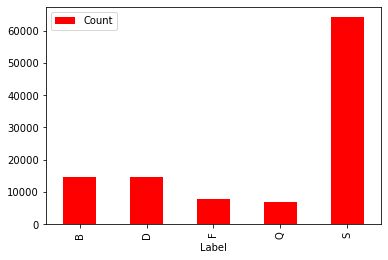

In [14]:
#Creating table of number of each data label present in the dataset
label_count=data.groupby('Basic')['Basic'].agg('count')
label_count.to_numpy(dtype=int)
label_count = np.expand_dims(label_count, axis=0)
label_count.shape=(5,1)
labels=np.array(['B', 'D', 'F', 'Q', 'S'])
labels.shape=(5,1)
label_count=np.column_stack((labels,label_count))

df = pd.DataFrame(label_count, columns=['Label', 'Count'])

convert_dict = {'Label': str,
                'Count': int
               }
  
df = df.astype(convert_dict)
# labels statistics,it seems like we have balanced data, since statement are the ones that are naturally the most used in a conversation
df.plot.bar(x = 'Label', y='Count', color='red')

In [14]:
#Tokenizing the words and padding the sentence
MAX_PADDING = 77
tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(data['Utterances'].values)
x_train = tokenizer.texts_to_sequences(data['Utterances'].values)
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_PADDING)
print(x_train.shape)
x_train[:2]

(108201, 77)


array([[ 11,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  36,  59,   4, 168,   4,  61,  81,  10,  97,  35,  15, 438,
         86, 659,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [15]:
y_train = pd.get_dummies(data['Basic']).values
[print(data['Basic'][i],y_train[i]) for i in range (0,5)]

F [0 0 1 0 0]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]
S [0 0 0 0 1]


[None, None, None, None, None]

#### Glove Embedding

In [20]:
f = open("../glove.6B/glove.6B.300d.txt",  encoding="utf8")  # using the Glove Embedding, see article for more explanation 
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [21]:
embedd_index['good']

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [22]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

11113


In [23]:
embedding_matrix = np.zeros((len(index_of_words) + 1, 300))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
embedding_matrix.shape

(11114, 300)

### Modeling & Evaluation 

In [24]:
embedd_layer = Embedding(input_dim=len(index_of_words) + 1 , 
                         output_dim=300 , 
                         input_length = 77 , 
                         weights = [embedding_matrix])

In [25]:
MAX_LENGTH_PER_SENTENCE=77
units = 128
encoder_input = keras.Input(shape=(MAX_LENGTH_PER_SENTENCE))
x = layers.Embedding(input_dim=len(index_of_words) + 1 , 
                     output_dim=300 , 
                     input_length = 77 , 
                     weights = [embedding_matrix])(encoder_input)
                              
activations = layers.Bidirectional(layers.LSTM(units, 
                                               dropout=0.3, 
                                               recurrent_dropout=0.2,
                                               return_sequences=True))(x)    # the use of BiLSTM

attention = layers.Dense(1, activation='tanh')(activations)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(units*2)(attention)
attention = layers.Permute((2, 1))(attention)

sent_representation = layers.Multiply()([activations, attention])
sent_representation = layers.Lambda(lambda X: K.sum(X, axis=-2), output_shape=(units*2,))(sent_representation)


probabilities = layers.Dense(5, activation='softmax')(sent_representation)


encoder = keras.Model(inputs=[encoder_input], outputs=[probabilities],name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 77, 300)      3334200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 77, 256)      439296      embedding_1[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 77, 1)        257         bidirectional[0][0]              
____________________________________________________________________________________________

In [26]:
encoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
#Early stopping the training when accuracy decreases
es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', patience=1, verbose=1)

In [29]:
encoder.fit(x_train, y_train, epochs=1, batch_size=32, callbacks=[es], verbose=1)   # one epochs because of computational resources

3382/3382 [==============================] - 2458s 726ms/step - loss: 0.5044 - accuracy: 0.8093


In [32]:
#Test set processing
test_set = pd.read_csv('../Datasets/MRDA/mrda_data/test_set.txt', sep='|')
test_set.columns=['Speaker','Utterances','Basic','General','Full']
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: x.lower())
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(test_set['Utterances'].values)
x_test = tokenizer.texts_to_sequences(test_set['Utterances'].values)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_PADDING)

y_test = pd.get_dummies(test_set['Basic']).values
[print(test_set['Basic'][i],y_test[i]) for i in range (0,5)]

S [0 0 0 0 1]
S [0 0 0 0 1]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]


[None, None, None, None, None]

##### Model Accuracy

In [33]:
score = encoder.evaluate(x_test, y_test)

522/522 [==============================] - 59s 105ms/step - loss: 1.9399 - accuracy: 0.5412


In [68]:
print('the model accuracy is then : 0.54')

the model accuracy is then : 0.54
